## Run XGBoost, Produce SHAP Visualization from PCA Input    

In [3]:
#(run pip install shap if you don't have)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)


C:\Users\Mickey\anaconda3\Lib\site-packages\shap\_explanation.py:10: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  import scipy.cluster


In [3]:
df = pd.read_csv('/Users/mcott/Desktop/UMich/Milestone II/trunc-svd_dbscan_fixed.csv',dtype={1: str})
#df.tail(5)

chi_bus_df = df[(df['mode'] == 'bus') & (df['state'] == 'CHI')]
chi_train_df = df[(df['mode'] == 'train') & (df['state'] == 'CHI')]
nyc_bus_df = df[(df['mode'] == 'bus') & (df['state'] == 'NYC')]
nyc_train_df = df[(df['mode'] == 'subway') & (df['state'] == 'NYC')]


#nyc_train_df.head(5)

In [29]:
'''
Mickeys Test


nyc_df = pd.read_csv('data/NYC_trunc.csv',low_memory=False)
chi_df = pd.read_csv('data/CHI_trunc.csv',low_memory=False)



# Split by mode
nyc_bus_df = nyc_df[nyc_df['mode'] == 'bus']
nyc_bus_df = nyc_bus_df.astype({col: 'int' for col in nyc_bus_df.select_dtypes(include='bool').columns})
nyc_subway_df = nyc_df[nyc_df['mode'] == 'subway']
nyc_subway_df = nyc_subway_df.astype({col: 'int' for col in nyc_subway_df.select_dtypes(include='bool').columns})
chi_bus_df = chi_df[chi_df['mode'] == 'bus']
chi_bus_df = chi_bus_df.astype({col: 'int' for col in chi_bus_df.select_dtypes(include='bool').columns})
chi_train_df = chi_df[chi_df['mode'] == 'train']
chi_train_df = chi_train_df.astype({col: 'int' for col in chi_train_df.select_dtypes(include='bool').columns})

'''


In [4]:
reduced_cols = ['us_aqi_mean',
 'us_aqi_pm2_5_mean',
 'us_aqi_pm10_mean',
 'us_aqi_nitrogen_dioxide_mean',
 'us_aqi_ozone_mean',
 'us_aqi_sulphur_dioxide_mean',
 'us_aqi_carbon_monoxide_mean',
 'apparent_temperature_max',
 'apparent_temperature_min',
 'apparent_temperature_max_lag',
 'apparent_temperature_min_lag',
 'relative_humidity_2m_mean','rain_sum',
 'rain_max',
 'snowfall_sum',
 'snowfall_max','wind_speed_10m_mean',
 'wind_speed_10m_max',
 'wind_direction_10m_mean',
 'date',
 'unit_id',
 'state',
 'mode',
 'daily_ridership']

reduced_df = df[reduced_cols]
reduced_df.head()

reduced_chi_bus_df = reduced_df[(reduced_df['mode'] == 'bus') & (reduced_df['state'] == 'CHI')]
reduced_chi_train_df = reduced_df[(reduced_df['mode'] == 'train') & (reduced_df['state'] == 'CHI')]
reduced_nyc_bus_df = reduced_df[(reduced_df['mode'] == 'bus') & (reduced_df['state'] == 'NYC')]
reduced_nyc_train_df = reduced_df[(reduced_df['mode'] == 'subway') & (reduced_df['state'] == 'NYC')]


### XGBoost

In [31]:
def XGBoost_SHAP(df): #add other hyperparameters here
    
    # Prepare data
    # invalid columns for model - 'date','unit_id','state','mode' 
    target_col = 'daily_ridership'
    X = df.drop(columns=[target_col,'date','unit_id','state','mode'])
    y = df[target_col]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
    
    # Train XGBoost model
    model = XGBRegressor(eval_metric='logloss')
    model.fit(X_train, y_train)

    # Evaluation Metrics
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cvs = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

    # SHAP values
    explainer = shap.Explainer(model, X_train, seed=9)
    shap_values = explainer(X_train)

    # Create SHAP Beeswarm plot (similar to summary plot, better performance with large datasets)
    plt.figure(figsize=(10, 8))
    shap.plots.beeswarm(shap_values, show=False)
    plt.title('SHAP Beeswarm Plot - Feature Importance')
    plt.tight_layout()
    plt.show()

    # SHAP Waterfall plot example (only shows feature importance for a single prediction)
    '''
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_train, show=False)
    plt.title('SHAP Summary Plot - Feature Importance')
    plt.tight_layout()
    plt.show()
    '''

    # SHAP force plot example (only shows feature importance for a single prediction)
    '''
    shap.force_plot(explainer.expected_value,shap_values[0], X_test.iloc[0, :], matplotlib=True)
    '''

    # Print evaluation metrics
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')
    print(f'Cross-Validation Scores: {cvs}')

    return model, X_train, X_test, y_train, y_test, shap_values, mae, r2, cvs

### SHAP Viz

100%|===================| 66692/66834 [02:11<00:00]        

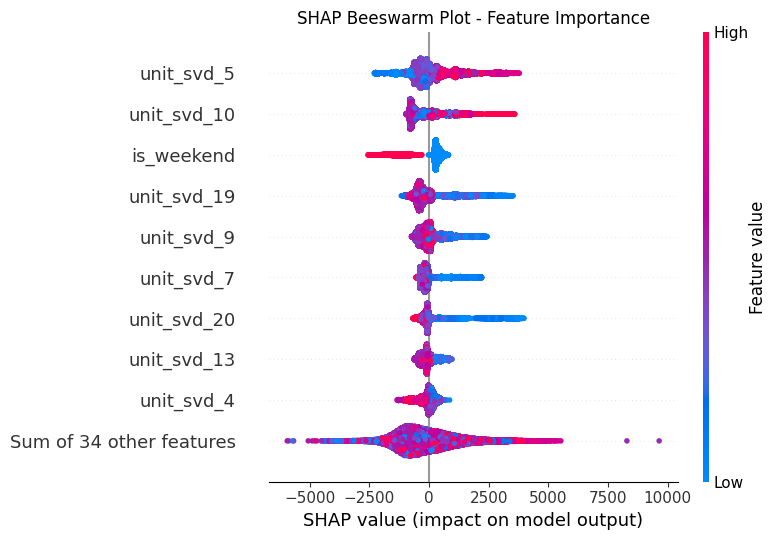

Mean Absolute Error: 370.81807130890166
R^2 Score: 0.9775967313665592
Cross-Validation Scores: [-2338.66661823 -2205.8831701  -2508.22052878 -2826.68055013
 -2799.64028714]


In [33]:
# Uncomment to run function for each dataset

mod_cb,X_train_cb,X_test_cb,y_train_cb,y_test_cb,chi_bus_SHAP, cbm, cbr2, cb_cvs = XGBoost_SHAP(chi_bus_df)
#mod_ct,X_train_ct,X_test_ct,y_train_ct,y_test_ct,chi_train_SHAP, ctm, ctr2, ct_cvs = XGBoost_SHAP(chi_train_df)
#mod_nb,X_train_nb,X_test_nb,y_train_nb,y_test_nb,nyc_bus_SHAP, nbm, nbr2, nb_cvs = XGBoost_SHAP(nyc_bus_df)
#mod_nt,X_train_nt,X_test_nt,y_train_nt,y_test_nt,nyc_train_SHAP, ntm, ntr2, nt_cvs = XGBoost_SHAP(nyc_train_df)